In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys
from tqdm import trange

from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.widgets import Slider, Button

In [7]:
def plot_cubes(matrix):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(matrix,edgecolor='k')

In [8]:
def add_cube(matrix):
    pad_matrix = np.pad(matrix,1)
    conv = np.array([[[0,0,0],[0,1,0],[0,0,0]]
                     ,[[0,1,0],[1,-10,1],[0,1,0]]
                     ,[[0,0,0],[0,1,0],[0,0,0]]])

    places = scipy.ndimage.convolve(pad_matrix,conv,mode='constant',cval=0)
    
    new_matrices = []
    for idx in np.argwhere(places>0):
        new_mat = pad_matrix.copy()
        new_mat[tuple(idx)] = 1
        new_matrices.append(new_mat)
    return new_matrices

In [40]:
def get_distances(matrix,n:int=None):
    dist_mat = scipy.spatial.distance_matrix(np.argwhere(matrix==1),np.argwhere(matrix==1))
    if not n:
        n = dist_mat.shape[0]
    distances = np.sort(dist_mat[np.triu_indices(n,k=1)])[::-1]
    return distances.copy(order='C')

In [60]:
new_df = pd.DataFrame(
    columns=[
        'id',
        'n',
        'matrix',
        'distances',
        'chiral'
    ],
    )

new_df.matrix = df.matrix.apply(add_cube).explode().tolist()

new_df.distances = new_df.matrix.apply(get_distances)
new_df['id'] = new_df.distances.apply(lambda x: hash(str(x)))
new_df = new_df.groupby(['id']).first()

new_df['n'] = new_df.matrix.apply(lambda x: len(np.argwhere(x==1)))

In [61]:
new_df

,n,matrix,distances,chiral
id,,,,
5388796946009220666,3,"[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, ...","[2.0, 1.0, 1.0]",None
6304324388246149593,3,"[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...","[1.4142135623730951, 1.0, 1.0]",None


In [403]:
def check_chiral(matrix):
    reflection = matrix[::-1].copy()
    matrix = shift_to_origin(matrix)

    reflection_x = np.rot90(reflection,2,axes=(1,2))
    reflection_x = shift_to_origin(reflection_x)
    reflection_y = np.rot90(reflection,2,axes=(0,2))
    reflection_y = shift_to_origin(reflection_y)
    reflection_z = np.rot90(reflection,2,axes=(0,1))
    reflection_z = shift_to_origin(reflection_z)
    if (np.array_equal(matrix, reflection_x)) | (np.array_equal(matrix, reflection_y))| (np.array_equal(matrix, reflection_z )):
        return False
    else:
        return True

def shift_to_origin(matrix):
    while not matrix[0,:,:].any():
        matrix = np.roll(matrix,-1,axis=0)
    while not matrix[:,0,:].any():
        matrix = np.roll(matrix,-1,axis=1)
    while not matrix[:,:,0].any():
        matrix = np.roll(matrix,-1,axis=2)
    return matrix

True


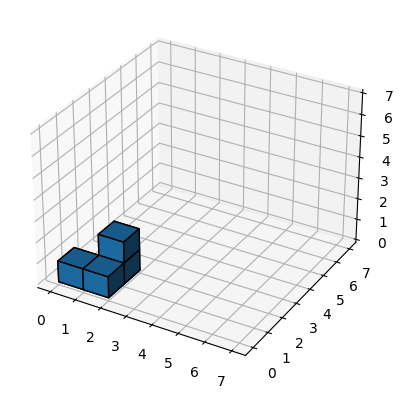

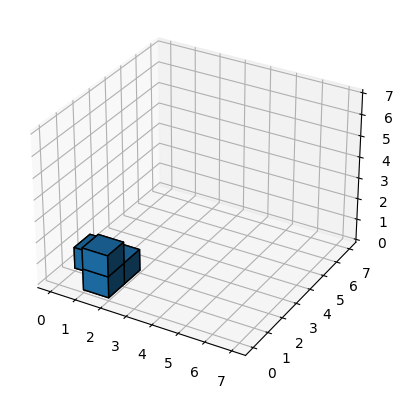

In [425]:
mat1 = list(cubes_list[3].values())[4]
mat1 = shift_to_origin(mat1)

mat2 = mat1.copy()
mat2 = mat2[::-1]
mat2 = np.rot90(mat2,2,axes=(0,1))
mat2 = shift_to_origin(mat2)
plot_cubes(mat1)
plot_cubes(mat2)

print(check_chiral(mat1))

In [119]:
def add_n(df):
    nmax = df.n.max()
    new_df = pd.DataFrame(
        columns=[
            'id',
            'n',
            'matrix',
            'distances',
            'chiral'
        ],
    )

    new_df.matrix = df.loc[df.n==nmax].matrix.apply(add_cube).explode().tolist()

    new_df.distances = new_df.matrix.apply(get_distances)
    new_df['id'] = new_df.distances.apply(lambda x: hash(str(x)))
    new_df = new_df.groupby(['id']).first().reset_index()

    new_df['n'] = new_df.matrix.apply(lambda x: len(np.argwhere(x==1)))
    
    df = pd.concat([df,new_df],axis=0,ignore_index=True)
    return df

In [120]:
df0 = pd.DataFrame(
    columns=[
        'id',
        'n',
        'matrix',
        'distances',
        'chiral'
    ],
    )
df0.loc[len(df0)] =  {
    
    'id':  hash(str(np.array([0]))),
    'n': 1,
    'matrix': np.array(
                        [[[1]]]
                        ,dtype='int8'
                        ),
    'distances': np.array([0]) ,
    'chiral': False
}

In [121]:
def add_till_n(n,df = df0):
    last_n = df.n.max()
    for i in range(n-last_n):
        df = add_n(df)
    return df

In [126]:
df = add_till_n(4,df0)

In [350]:
n = 4
vals = list(cubes_list[n-1].values())

@interact(x=(0,len(cubes_list[n-1])-1))
def plot(x):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(vals[x],edgecolor='k')
    plt.title('n = {} blocks'.format(n))
    plt.show()

interactive(children=(IntSlider(value=3, description='x', max=6), Output()), _dom_classes=('widget-interact',)…

In [114]:
A = np.argwhere(vals[4])
B = A[::-1].copy()
B

array([[5, 4, 3],
       [4, 4, 3],
       [4, 3, 3],
       [3, 3, 3]], dtype=int64)